In [1]:
! pip install transformers datasets
!pip install kaggle
! pip install datasets
!pip install evaluate
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
from transformers import DefaultDataCollator
! pip install -U accelerate
! pip install -U transformers[torch]

##Download the data and put it into a DataSet object

Download the data from Kaggle

In [2]:
!kaggle datasets download -d lantian773030/pokemonclassification

Dataset URL: https://www.kaggle.com/datasets/lantian773030/pokemonclassification
License(s): copyright-authors
pokemonclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


unzip the downloaded file

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/pokemonclassification.zip','r')
zip_ref.extractall('/content/')
zip_ref.close()

Load it as a DataSet object

In [4]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/PokemonData")

Resolving data files:   0%|          | 0/6837 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Look at an example

In [5]:
dataset
dataset['train'][6000]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x758>,
 'label': 133}

Split the dataset train/test

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.1)

Verification that we have all types of Pokemon in the test set

In [7]:
np.unique(dataset["test"][:]['label'])

array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149])

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:

In [8]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [9]:
id2label[str(70)]

'Lickitung'

##Preprocess the data

Load a ViT image processor

In [10]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Apply transformations () to augment the dataset and make it more robust

In [11]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Create a pre-processing function

In [12]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

Apply the pre-processing function to the dataset

In [13]:
pokemons = dataset.with_transform(transforms)

Create batch of examples

In [14]:
data_collator = DefaultDataCollator()

##Evaluate

In [15]:
accuracy = evaluate.load("accuracy")

Create a function that passes your predictions and labels to compute the accuracy

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

##Train

In [17]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
    output_dir="pokemons_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=pokemons["train"],
    eval_dataset=pokemons["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.761000,4.714927,0.334311
2,4.313600,4.321548,0.649560
3,4.154300,4.191793,0.706745


TrainOutput(global_step=288, training_loss=4.524226188659668, metrics={'train_runtime': 377.4465, 'train_samples_per_second': 48.786, 'train_steps_per_second': 0.763, 'total_flos': 1.4288302968001413e+18, 'train_loss': 4.524226188659668, 'epoch': 3.0})

##Inference

###Look at an example from the dataset

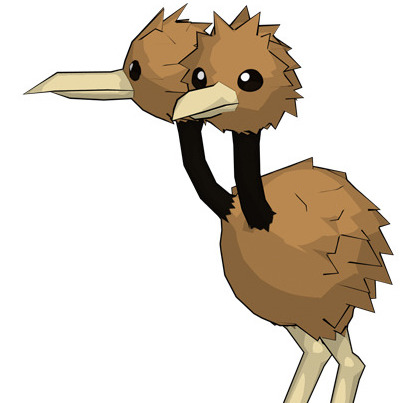

In [72]:
img = dataset["test"][0]
img['image']

We pre-process the image using our model

In [73]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("pokemons_model/checkpoint-288/")
inputs = image_processor(img['image'], return_tensors="pt")

Logit prediction

In [74]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("pokemons_model/checkpoint-288/")
with torch.no_grad():
    logits = model(**inputs).logits

In [75]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'Dodrio'

Check the actual label

In [76]:
labels[img['label']]

'Doduo'

There is a confusion between "Doduo" and "Dodrio". What is the second prediction?

In [88]:
import pandas as pd
df_logits = pd.DataFrame(logits).transpose()
df_logits.nlargest(2,0)

,0
24,0.969999
25,0.631884


Ok the second best prediction is the 25th

In [89]:
model.config.id2label[25]

'Doduo'

Works! Effectively some pokemon are very close to each other

###Manually upload an example

Import the file

In [60]:
from google.colab import files
uploaded = files.upload()

Saving pikachu jpeg.jpg to pikachu jpeg.jpg


Convert it to an image

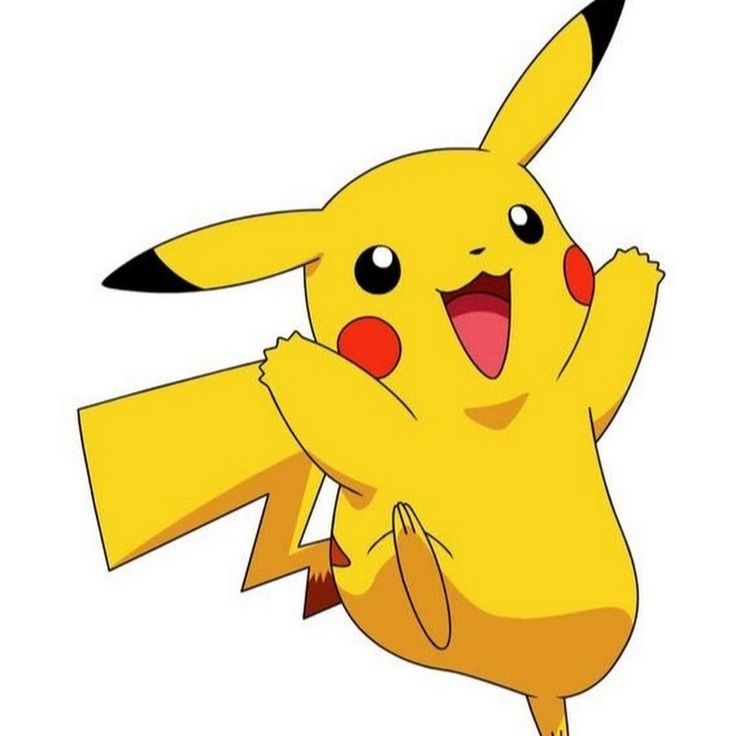

In [67]:
from io import BytesIO
from PIL import Image

im = Image.open(BytesIO(uploaded['pikachu jpeg.jpg']))
im

Prediction

In [71]:
inputs = image_processor(im, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'Pikachu'

Works!